# Linear Regression Assignment
## Bike Sharing Analysis

#### Problem Statement:

BoomBikes want to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands


In [1]:
# Load the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.model_selection import train_test_split
from   sklearn.feature_selection import RFE
from   sklearn.linear_model import LinearRegression
from   sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from   statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the data from the csv file provided
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Step 1: Initial Data Analysis

In [3]:
# Check for nulls and unexpected datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# Observations
 - There are 730 rows
 - There are 16 columns
 - Each variable has 730 non-null variables so no null entries
 - All data types are as I would expect indicating that there are no obvious incorrect values


In [4]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# Observations
all the numbers appear to be in expected ranges based on the information provided. 
The only expection is the weathersit field.  The description indicates a scale from 1-4
but a scale of 1-3 is observed.  This indicates there was no weather of type 4 observed. 

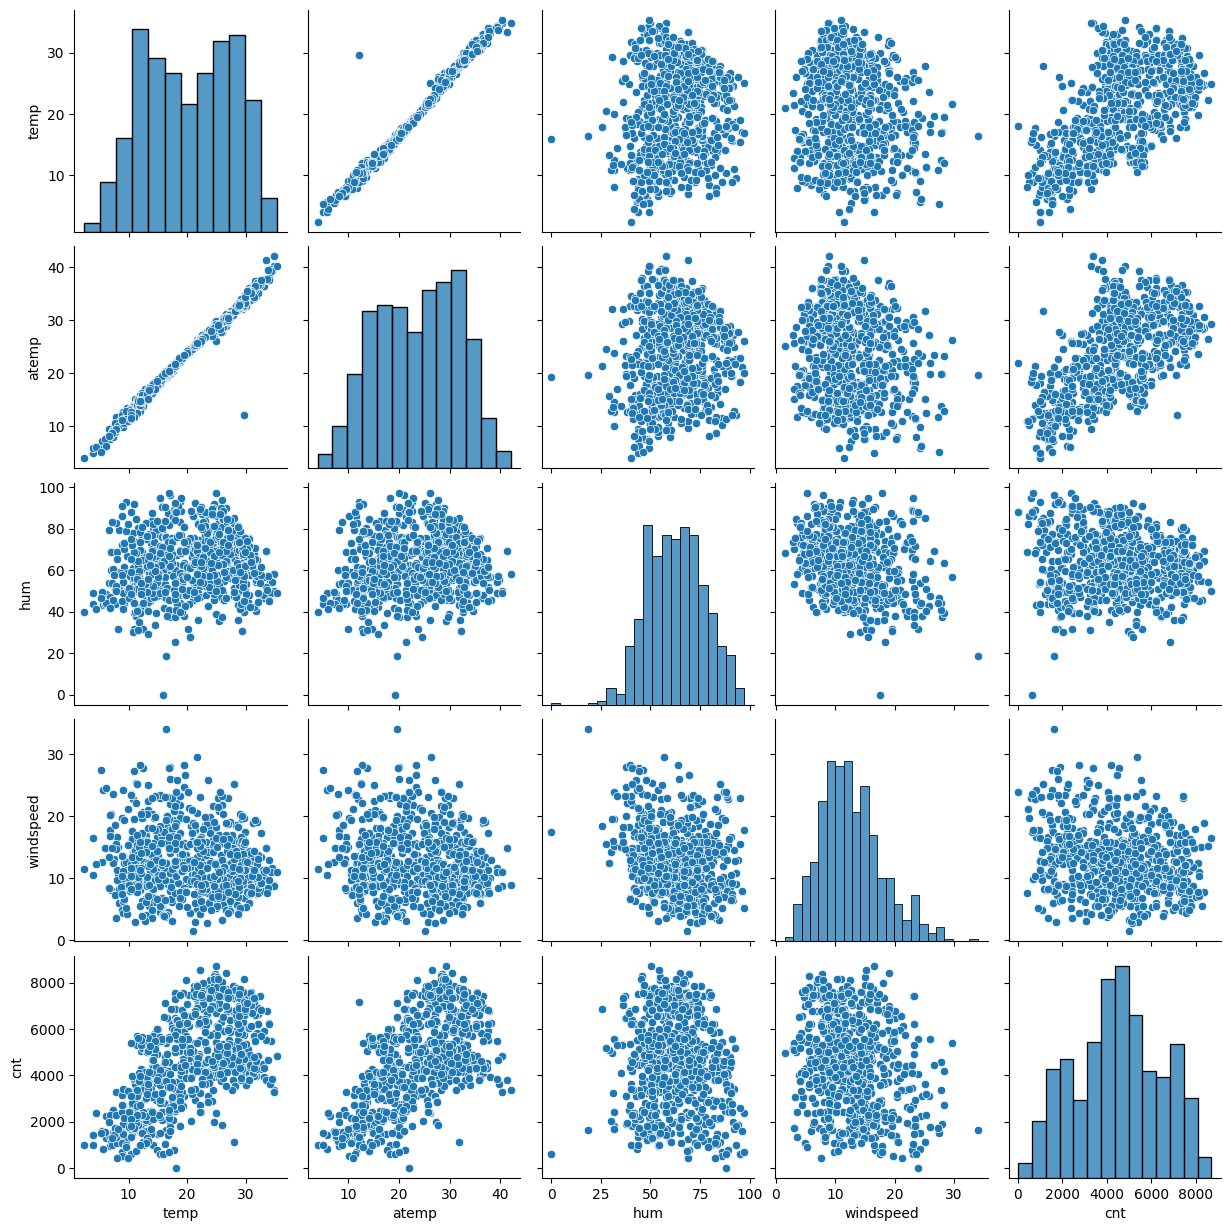

In [5]:
# create a pairplot of the continuous features
sns.pairplot(df[['temp','atemp','hum','windspeed','cnt']])
plt.show()

# Observations
- The distribution of cnt values is approximately normal
- It looks like there is a strong correlation between temp and atemp.  This is an indicator of multicollinearity.
- There appears to be a positive correlation between cnt and temp and atemp
- There appears to be a slight negative correlation between windspeed and cnt
- The looks like there may be a few outliers on hum.
- If you ignore suspected outliers there appears to be a negative correlation between hum and cnt



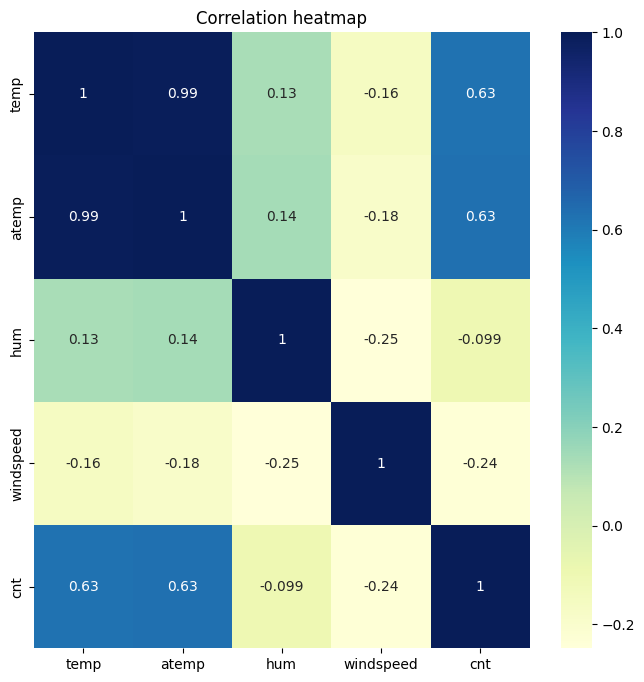

In [6]:
# check for correlations between the continuous features and the target variable
plt.figure(figsize = (8, 8))
sns.heatmap(df[['temp','atemp','hum','windspeed','cnt']].corr(), annot = True, cmap="YlGnBu")
plt.title("Correlation heatmap")
plt.show()

# Observations
- There is a high correlation between temp and atemp as suspected
- There both have the same correlation factor to the target variable
- As temperature is a direct observation I will remove the atemp column

In [7]:
df.drop(['atemp'],axis=1,inplace=True)

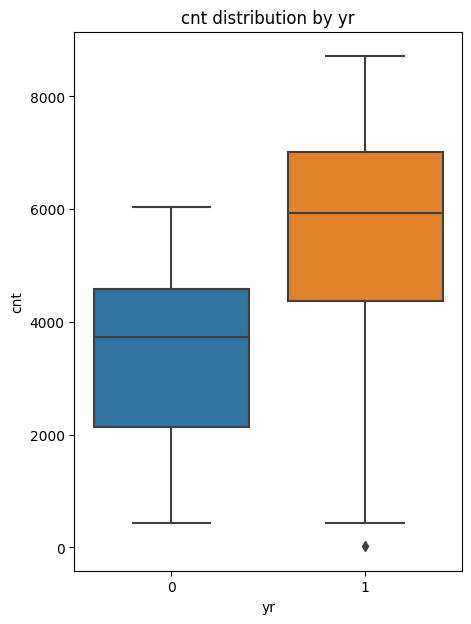

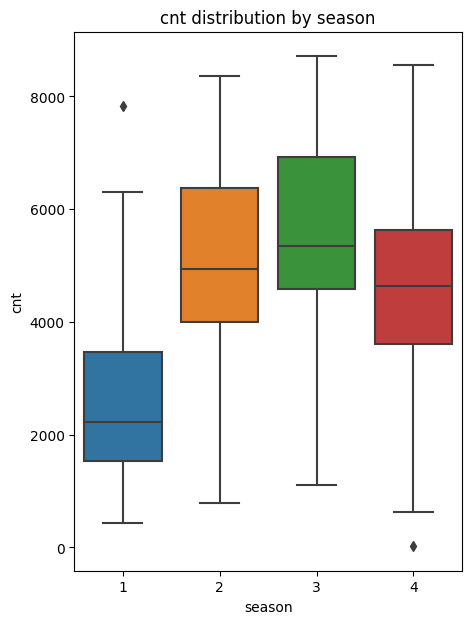

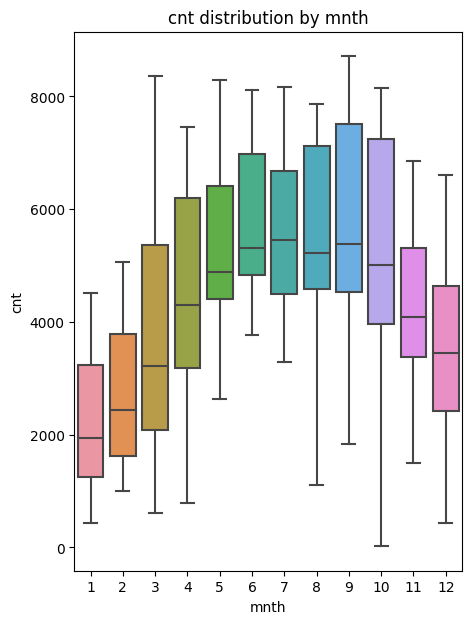

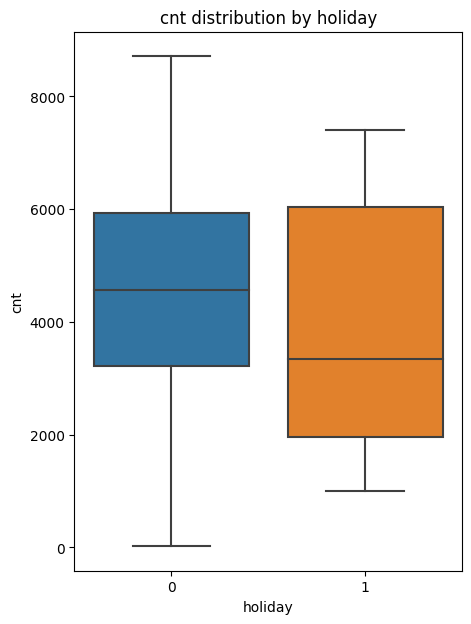

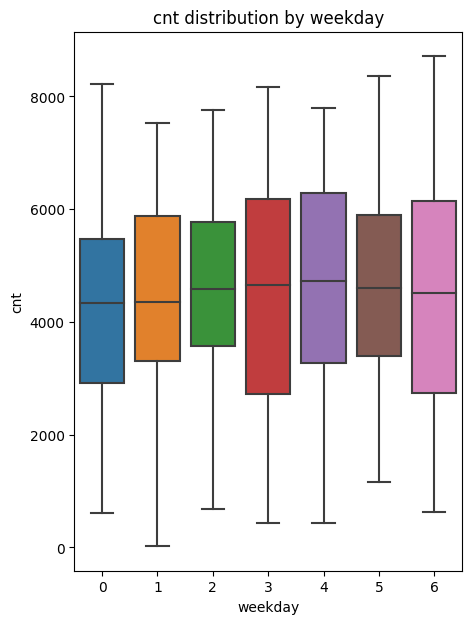

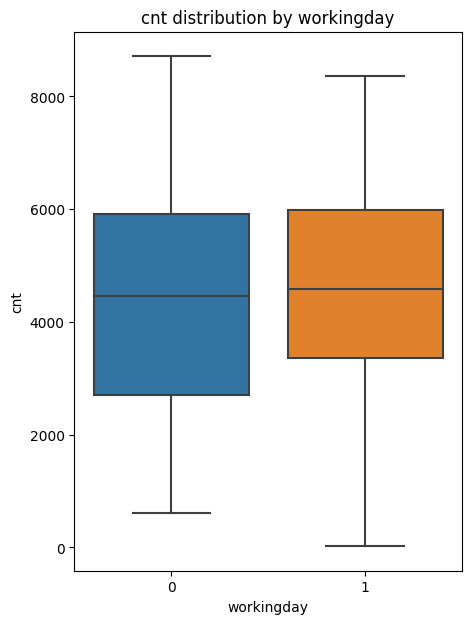

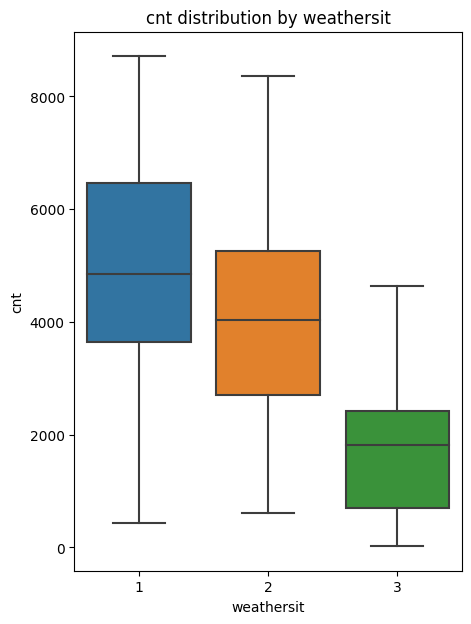

In [8]:
# Box plot the categorical features
categorical_fields = ['yr','season','mnth','holiday','weekday','workingday','weathersit']
for cat in categorical_fields:
    plt.figure(figsize = (5, 7))
    sns.boxplot(x = cat, y = 'cnt', data = df)
    plt.title("cnt distribution by " + cat)
    plt.show()

# Observations
- All the fields have the expected values (except weathersit as previously mentioned)
- year, season, month, holiday and weathersit appear to have a larger impact on the cnt
- working day and weekday have a much smaller impact
- There are a few outliers that need to be dealt with

In [9]:
# check how many outliers there are based on the values observered in the boxplots
print(df[((df['season']==1)&(df['cnt']>7000))].dteday)
print(df[((df['season']==4)&(df['cnt']<100))].dteday)
print(df[((df['yr']==1)&(df['cnt']<100))].dteday)


440    17-03-2019
Name: dteday, dtype: object
666    29-10-2019
Name: dteday, dtype: object
666    29-10-2019
Name: dteday, dtype: object


In [10]:
# there are two rows that are causing the outliers
# lets remove them
df = df[~((df['season']==1)&(df['cnt']>7000))]
df = df[~((df['season']==4)&(df['cnt']<100))]


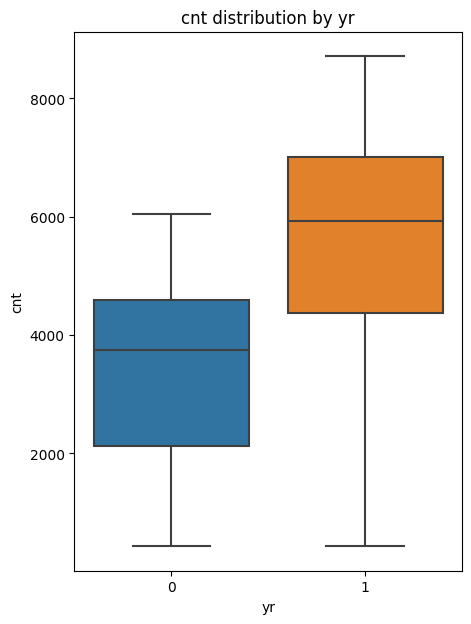

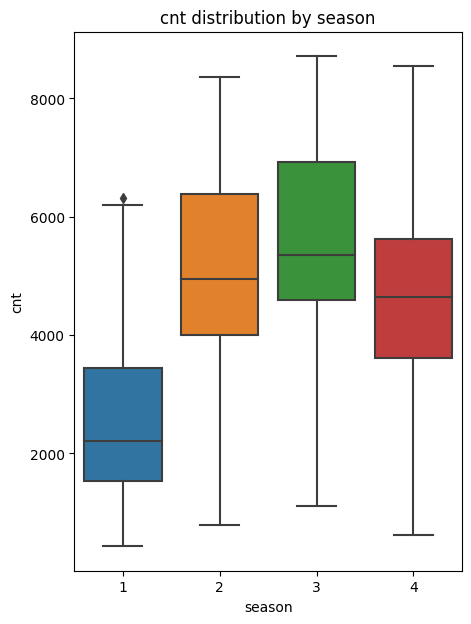

In [11]:
# create box plots for the two features that previously had outliers
categorical_fields = ['yr','season']
for cat in categorical_fields:
    plt.figure(figsize = (5, 7))
    sns.boxplot(x = cat, y = 'cnt', data = df)
    plt.title("cnt distribution by " + cat)
    plt.show()

# Observations
- The boxplots show the outliers have been removed

# Drop some usless features
Based on the description, the 'casual' and 'registered' variables
are not independent, they have a direct link ('casual' + 'registered' = 'cnt')
to the target variable and therefore are not available for forecasting.

The instant variable is just an index and hold no value.

In [12]:
# Drop the variables that can not be used.
df.drop(['instant','casual','registered'],axis=1,inplace=True)

# Examine the continuous features

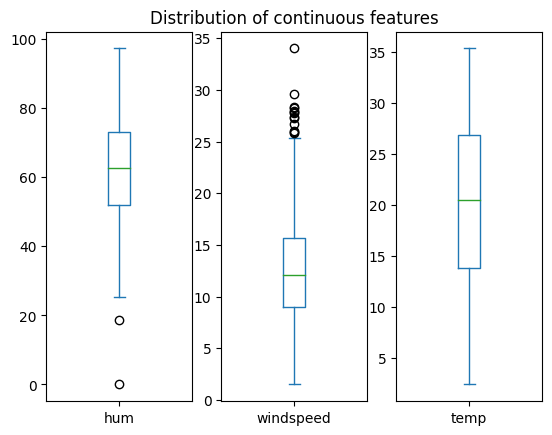

In [13]:
# Create a box plot of the continuous features
fig, axs = plt.subplots(1, 3)
axs[1].set_title("Distribution of continuous features")
df['hum'].plot.box( ax=axs[0])
df['windspeed'].plot.box(ax=axs[1])
df['temp'].plot.box(ax=axs[2])
plt.show()

# Observations

- It shows that humidity has outliers below the lower bound
- One of the outliers has a humidity value of 0 which is almost certainly incorrect
- It shows that the windspeed feature has outliers above the upper bound. 

In [14]:
# check for outliers by looking for values 1.5 * the interquartile range below the lower quartile 
# or above the upper quartile
def OutlierCheck(df):
    description = df.describe()
    IQR = (description.loc["75%"]-description.loc["25%"])
    LB = description.loc["25%"] - (IQR * 1.5)
    UB = description.loc["75%"] + (IQR * 1.5)
    Outliers = (description.loc["min"] < LB) | (description.loc["max"] > UB)
    results = pd.concat([IQR,LB,UB,Outliers],axis=1)
    results.columns=['IQR','LB','UB','Outliers']
    print(results,'\n')

OutlierCheck(df[['temp','hum','windspeed']])

                 IQR         LB          UB  Outliers
temp       13.094354  -5.846733   46.530685     False
hum        20.979125  20.510488  104.426987      True
windspeed   6.583504  -0.833606   25.500409      True 



In [15]:
# find the humidity outliers using the calculated lower boundary
print (df[(df['hum']<20.51)].shape[0], ' outliers detected')

# find the windspeed outliers using the calculated upper boundary 
print(df[(df['windspeed']>25.5)].shape[0], ' outliers detected')

2  outliers detected
13  outliers detected


In [16]:
# There is not a large volume of outliers (<3% of records) so remove them 
df = df[~(df['hum']<20.51)]
df = df[~(df['windspeed']>25.5)]

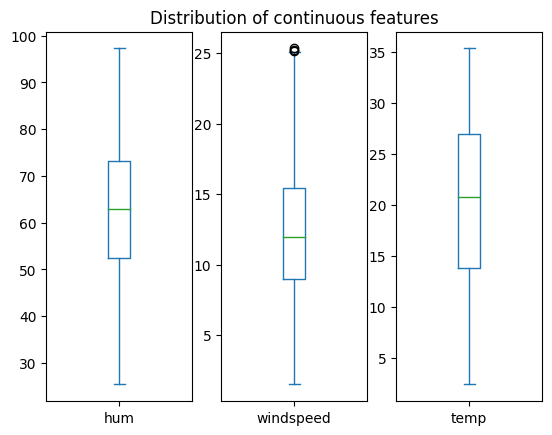

In [17]:
# check the box plots again to see if the outliers have been removed
fig, axs = plt.subplots(1, 3)
axs[1].set_title("Distribution of continuous features")
df['hum'].plot.box( ax=axs[0])
df['windspeed'].plot.box(ax=axs[1])
df['temp'].plot.box(ax=axs[2])
plt.show()

There are still some outliers showing from windspeed but they are very close to the upper boundary
The plot must have used a different calculation to identify outliers.

In [18]:
# check for duplicates
print(df.duplicated().sum(), "duplicates found")

0 duplicates found


# Step 2: Prepare the data
- Map the numberic values provided to logical labels
- Create dummy columns 
- Remove the categorical columns

In [19]:
# lets recode the season feature based on the details in the readme.txt
# season : season (1:spring, 2:summer, 3:fall, 4:winter)
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

# now create dummy variables
season_cols = pd.get_dummies(drop_first=True, data=df['season'])

season_cols

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
725,1,0,0
726,1,0,0
727,1,0,0
728,1,0,0


In [20]:
# lets recode the mnth feature
# Looking at the dteday feature I can see that 1 = jan, 2 = feb etc.
df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})

# now create dummy variables
mnth_cols = pd.get_dummies(drop_first=True, data=df['mnth'])

mnth_cols

,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,0,0,0,0,0,0,0,0,0
726,0,1,0,0,0,0,0,0,0,0,0
727,0,1,0,0,0,0,0,0,0,0,0
728,0,1,0,0,0,0,0,0,0,0,0


<span style="color:red"># Data Quality Issue</span>

looking at the date in dteday field in the data it appears that 0 is Tuesday, 1 is Wednesday etc.
however day 6 and day 0 are non-working days.

This is strange as I would expect Saturday and Sunday, not Monday and Tuesday to be non working days in the US
(where the company is based) 

looking closly at the other date related columns I can see that 1st Jan has a season of Spring.  
As this is a US company the 1st of Jan should be in Winter.

I suspect the dteday and mnth fields may be incorrect.

At this point I would go back to the company and raise my concerns and stress that any insight gained may not be reliable

For the purposes of the assessment I will proceed with the values provided 

In [21]:
# lets recode the weekday feature
# looking at the date field in the data it appears that 0 is Tuesday, 1 is Wednesday
df['weekday'] = df['weekday'].map({0: 'tue', 1:'wed', 2:'thu', 3:'fri', 4:'sat', 5:'sun', 6:'mon'})

# now create dummy variables
day_cols = pd.get_dummies(drop_first=True, data=df['weekday'])

day_cols

,mon,sat,sun,thu,tue,wed
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
725,0,1,0,0,0,0
726,0,0,1,0,0,0
727,1,0,0,0,0,0
728,0,0,0,0,1,0


In [22]:
# lets recode the weathersit feature
# i assigned labels based on the descriptions in the readme.txt
df['weathersit'] = df['weathersit'].map({ 1:'MostlyClear', 2:'Mist', 3:'LightPrecipitation', 4:'HeavyPrecipitation'})

# now create dummy variables
weather_cols = pd.get_dummies(drop_first=True, data=df['weathersit'])

weather_cols

,Mist,MostlyClear
0,1,0
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
725,1,0
726,1,0
727,1,0
728,0,1


In [23]:
# merge all the columns in to the dataframe

df = pd.concat([df,season_cols,mnth_cols,day_cols,weather_cols], axis=1)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,...,oct,sep,mon,sat,sun,thu,tue,wed,Mist,MostlyClear
0,01-01-2018,spring,0,jan,0,mon,0,Mist,14.110847,80.5833,...,0,0,1,0,0,0,0,0,1,0
1,02-01-2018,spring,0,jan,0,tue,0,Mist,14.902598,69.6087,...,0,0,0,0,0,0,1,0,1,0
2,03-01-2018,spring,0,jan,0,wed,1,MostlyClear,8.050924,43.7273,...,0,0,0,0,0,0,0,1,0,1
3,04-01-2018,spring,0,jan,0,thu,1,MostlyClear,8.200000,59.0435,...,0,0,0,0,0,1,0,0,0,1
4,05-01-2018,spring,0,jan,0,fri,1,MostlyClear,9.305237,43.6957,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# drop the categorical features and dteday as it's no longer required
df.drop(['dteday','season','mnth','weekday','weathersit'],axis=1, inplace=True) 

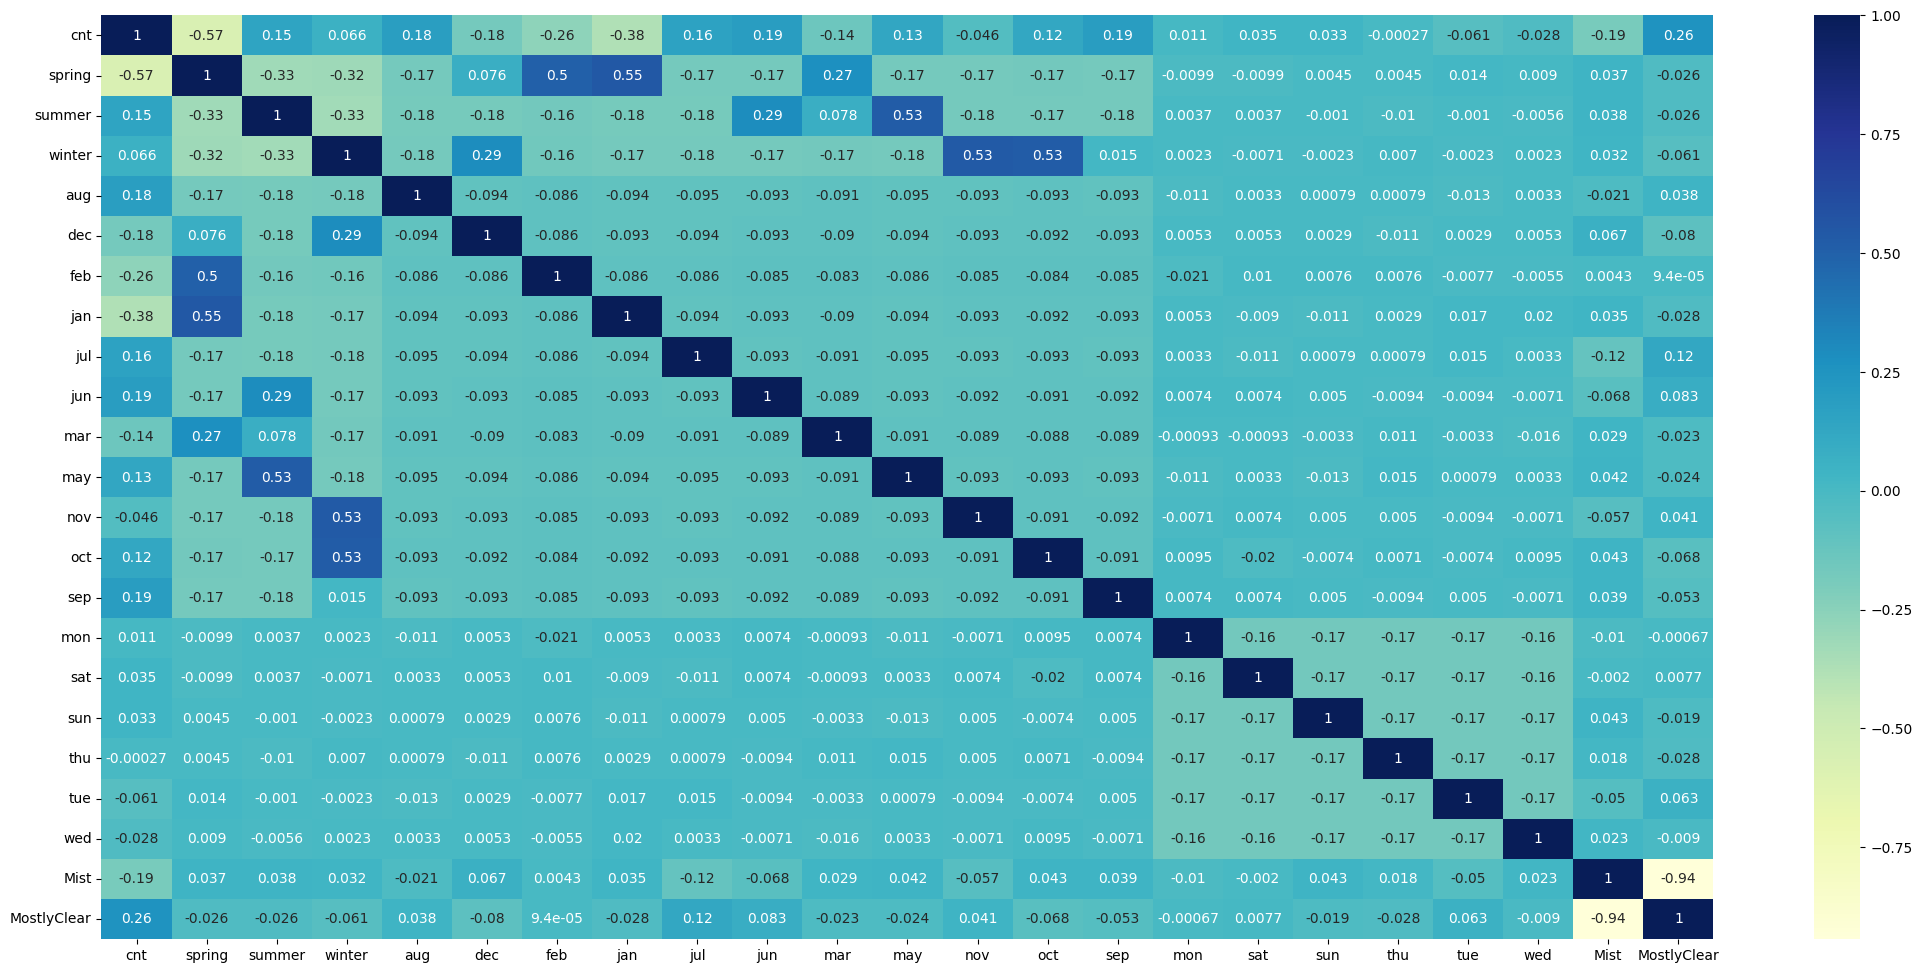

In [25]:
# Create a heatmap of the new dummy variables to ensure they have a linear relationship with the target variable
plt.figure(figsize = (26, 12))
sns.heatmap(df.drop(['temp','hum','windspeed','yr','workingday','holiday'],axis=1).corr(), annot = True, cmap="YlGnBu")
plt.show()

# Observations

- There is a strong negative correlation between Mist and MostlyClear.  
- You can see that the months and the seasons don't quite match up 
- I will continue to build the model before I decide which one to delete


# Step 3: Create training and testing dataframes 

In [26]:
# split the data in to train and test dataframes
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 1)



# Step 4: Scale the training dataframes

As the company would like to understand how each feature impacts demand, I'll scale the independent variables and target variable to all fall within the range of 0 and 1.  This will allow us to find the maximum coefficient and therefore indentify the independent variables that describe the largest amount of the variance in the target variable. 

Scaling will also help the model fitting process.

Scaling is done after the split to prevent data from the test dataframe leaking into the training dataframes

In [27]:

# Scale the features using the min/max scaler from scikit learn 
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the boolean and 'dummy' variables
num_vars = [ 'temp', 'hum', 'windspeed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

# Split the train dataframe in to X_train containing the features
# and y_train containing the dependant variable
y_train = df_train.pop('cnt')
X_train = df_train


# Step 5: Model Creation

As we only have 28 independent variables I have decided to remove half of the features using RFE
and then remove the last few systematically until I have an optimal model.

To keep the model concise and reduce the risk of overfitting I will aim to build a model with only 10 observed independent variables and a constant. 

In [28]:
# before we remove any features lets fit a model to act as a baseline

# There may be a group of customers that will high a bike regardless of the day, weather or any other recorded feature
# To account for these we will add a constant feature to the model. 
X_train_bl = sm.add_constant(X_train)

# Create a first fitted model
lr_bl = sm.OLS(y_train, X_train_bl).fit()

# Print a summary of the linear regression model obtained
print(lr_bl.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     112.9
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          4.77e-203
Time:                        15:24:49   Log-Likelihood:                 567.92
No. Observations:                 571   AIC:                            -1080.
Df Residuals:                     543   BIC:                            -958.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0407      0.041      0.989      

# Observations
- The model summary contains a warning in the notes regarding multicollinearity
- I will check the VIF scores to see if there is a problem

In [29]:
# Check for multicolinearity

# Create a function that takes two parameters and prints the dataframe that will contain the names of all the feature variables and their respective VIFs
def check_vif(df):

    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

check_vif(X_train_bl)

       Features    VIF
2       holiday    inf
3    workingday    inf
25          tue    inf
21          mon    inf
28  MostlyClear  12.27
7        spring  11.09
27         Mist  10.03
9        winter   9.29
8        summer   8.75
18          nov   7.74
4          temp   7.62
13          jan   6.91
19          oct   6.59
14          jul   6.30
11          dec   6.17
10          aug   5.88
12          feb   5.62
20          sep   5.00
16          mar   2.94
15          jun   2.75
5           hum   2.23
17          may   2.20
26          wed   1.92
22          sat   1.83
23          sun   1.80
24          thu   1.80
6     windspeed   1.19
1            yr   1.07
0         const   0.00


# Observations
looking at the VIF you can see that holiday, workingday, mon and tue have high correlations with other features

This makes sense. e.g

if a day is not a working day & not mon & not tue then it must be a holiday

if a day is not a working day & not mon & not a holiday then it must be a tue

dropping one of these columns will remove the multicollinearity

Based on the understanding of the data we know we can delete one of these fields without degrading the accuracy of the model

The working day feature correlates most with the other day features. lets drop that before we run RFE

In [30]:
# Drop the workingday feature and update the model
X_train = X_train.drop(['workingday'], axis = 1)

X_train_bl = sm.add_constant(X_train)

lr_bl = sm.OLS(y_train, X_train_bl).fit()

# Print a summary of the linear regression model obtained
print(lr_bl.summary())

# Check the VIF
check_vif(X_train_bl)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     112.9
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          4.77e-203
Time:                        15:24:49   Log-Likelihood:                 567.92
No. Observations:                 571   AIC:                            -1080.
Df Residuals:                     543   BIC:                            -958.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0789      0.052      1.531      

# Observations 
- The model R2 and adjusted R2 remained constant as expected

# Step 6: Feature reduction

As we only have 28 independent variables I have decided to remove half of the features using RFE
and then remove the last few systematically until I have an optimal model.

In [31]:
# Running RFE with the output number of the variable equal to 14
rfe = RFE(estimator=LinearRegression(), n_features_to_select=14)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', True, 1),
 ('dec', False, 7),
 ('feb', False, 9),
 ('jan', True, 1),
 ('jul', False, 8),
 ('jun', False, 5),
 ('mar', False, 4),
 ('may', False, 3),
 ('nov', False, 10),
 ('oct', True, 1),
 ('sep', True, 1),
 ('mon', False, 6),
 ('sat', False, 13),
 ('sun', False, 14),
 ('thu', False, 11),
 ('tue', False, 2),
 ('wed', False, 12),
 ('Mist', True, 1),
 ('MostlyClear', True, 1)]

In [32]:
# filter to include the columns identified by RFE
cols = X_train.columns[rfe.support_]
X_train_1 = X_train[cols]

# add the constant in again .
X_train_1 = sm.add_constant(X_train_1)

# Create a first fitted model
lr_1 = sm.OLS(y_train, X_train_1).fit()

# Print a summary of the linear regression model obtained
print(lr_1.summary())

# before we start removing more features lets look at the VIF 
# and check for multicolinearity
check_vif(X_train_1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     211.8
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.53e-212
Time:                        15:24:49   Log-Likelihood:                 555.52
No. Observations:                 571   AIC:                            -1081.
Df Residuals:                     556   BIC:                            -1016.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0426      0.043      0.998      

# Observations

- All features have a  low P>|t| value apart from const.
- A couple have a high VIF (MostlyClear & Mist)
- Both fields with high VIF have P>|t| = 0.00
- Drop MostlyClear as it has the highest VIF and then rebuild the model

In [33]:
# Create a second fitted model with MostlyClear removed
X_train_2 = X_train_1.drop(['MostlyClear'], axis = 1)
lr_2 = sm.OLS(y_train, X_train_2).fit()
# Print a summary of the linear regression model obtained
print(lr_2.summary())

check_vif(X_train_2)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     203.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          8.79e-202
Time:                        15:24:49   Log-Likelihood:                 528.06
No. Observations:                 571   AIC:                            -1028.
Df Residuals:                     557   BIC:                            -967.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2592      0.033      7.868      0.0

# Observations
- The P value of mist has increased slightly
- Lets try removing Mist instead

In [34]:
# Create a second fitted model
X_train_3 = X_train_1.drop(['Mist'], axis = 1)
lr_3 = sm.OLS(y_train, X_train_3).fit()
# Print a summary of the linear regression model obtained
print(lr_3.summary())

check_vif(X_train_3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     212.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          4.12e-206
Time:                        15:24:49   Log-Likelihood:                 538.32
No. Observations:                 571   AIC:                            -1049.
Df Residuals:                     557   BIC:                            -987.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1973      0.035      5.700      

- Removing Mist gives much better results
- The P>|t| value of MostlyClear is 0.00 and the R2 has improved
- Jan has a p-value greater than 0.05 so lets remove that


In [35]:
# remove jan and retrain
X_train_4 = X_train_3.drop(['jan'], axis = 1)
lr_4 = sm.OLS(y_train, X_train_4).fit()
# Print a summary of the linear regression model obtained
print(lr_4.summary())

check_vif(X_train_4)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     229.1
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          1.50e-206
Time:                        15:24:49   Log-Likelihood:                 536.55
No. Observations:                 571   AIC:                            -1047.
Df Residuals:                     558   BIC:                            -990.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1869      0.034      5.460      

- All features have p value > 0.05
- spring has a VIF above 5 lets remove it

In [36]:
# spring has a high VIF lets remove it and retrain
X_train_5 = X_train_4.drop(['spring'], axis = 1)
lr_5 = sm.OLS(y_train, X_train_5).fit()
# Print a summary of the linear regression model obtained
print(lr_5.summary())
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
check_vif(X_train_5)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     246.1
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          4.60e-206
Time:                        15:24:49   Log-Likelihood:                 532.54
No. Observations:                 571   AIC:                            -1041.
Df Residuals:                     559   BIC:                            -988.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1213      0.025      4.821      

- all features have a p-value < 0.05
- all features have a VIF value < 5
- We need to remove one more field to meet the required number of features
- we can either remove oct as it has the highest p-value or try to reduce the VIF of hum.
- Lets check what correlates with hum



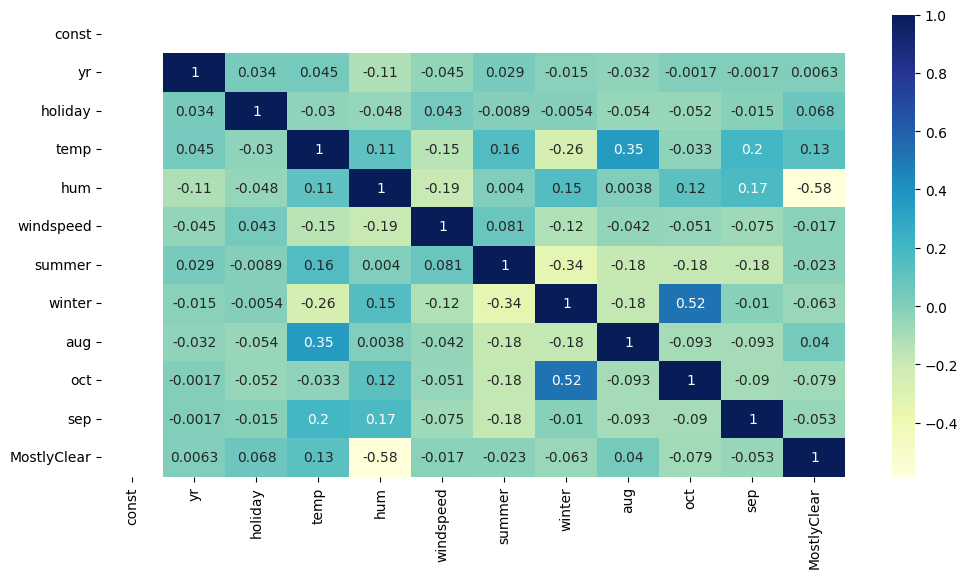

In [37]:
# hum now has the highest VIF (excluding const) but also still has a high coefficient
# I will look at the fields that correlate with it
plt.figure(figsize = (12, 6))
sns.heatmap(X_train_5.corr(), annot = True, cmap="YlGnBu")
plt.show()

- oct has a correlation with hum and the highest p-value. lets remove that

In [38]:
# oct has a correlation with hum and the highest p-value
X_train_6 = X_train_5.drop(['oct'], axis = 1)
lr_6 = sm.OLS(y_train, X_train_6).fit()
# Print a summary of the linear regression model obtained
print(lr_6.summary())

check_vif(X_train_6)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     264.4
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          1.01e-204
Time:                        15:24:50   Log-Likelihood:                 526.49
No. Observations:                 571   AIC:                            -1031.
Df Residuals:                     560   BIC:                            -983.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1153      0.025      4.548      

I now have a model built using the required number of features where:
 - All p>|t| = 0.00 for all features
 - All VIF are < 5 with the exception of the constant
 - 10 observed features and a constant

In [39]:
# create a final model and train dataset
lr_final = lr_6
X_train_final = X_train_6

# Step 7: Make prediction on the test set and evaluate the final model

In [40]:
#scale df_test
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = [ 'temp', 'hum', 'windspeed','cnt']
df_test_scaled = df_test.copy()
# don't refit the model just run the existing transform.
df_test_scaled[num_vars] = scaler.transform(df_test_scaled[num_vars])

#split in to X_test and y_test
y_test = df_test_scaled.pop('cnt')
X_test = df_test_scaled

#add the constant field
X_test = sm.add_constant(X_test)

#filter X_test to only contain the selected columns
cols = X_train_final.columns
X_test = X_test[cols]


In [41]:
# create test predictions
y_test_pred = lr_final.predict(X_test)

Text(0, 0.5, 'y_pred')

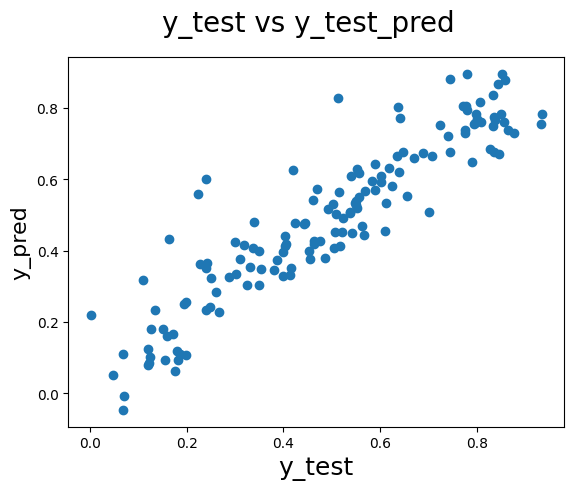

In [42]:
# Evaluate results
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

- the results look reasonable

In [43]:
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pred)

0.8408724290124021

The R-Score of 0.84 also looks reasonable

# Step 8: check the assumptions
The assumptions to be checked are: 
- There is a linear relationship between each predictor variable and the response  
- No Multicollinearity 
- Observations are independent 
- Homoscedasticity
- Multivariate normality I will create a distribution plot and a Q-Q plot of the residuals to confirm they have a normal distribution

### There is a linear relationship between each predictor variable and the response

I will validate this by observing a pair plot of the chosen features and by checking the resulkts of the t-test for each feature in the OLS model summary

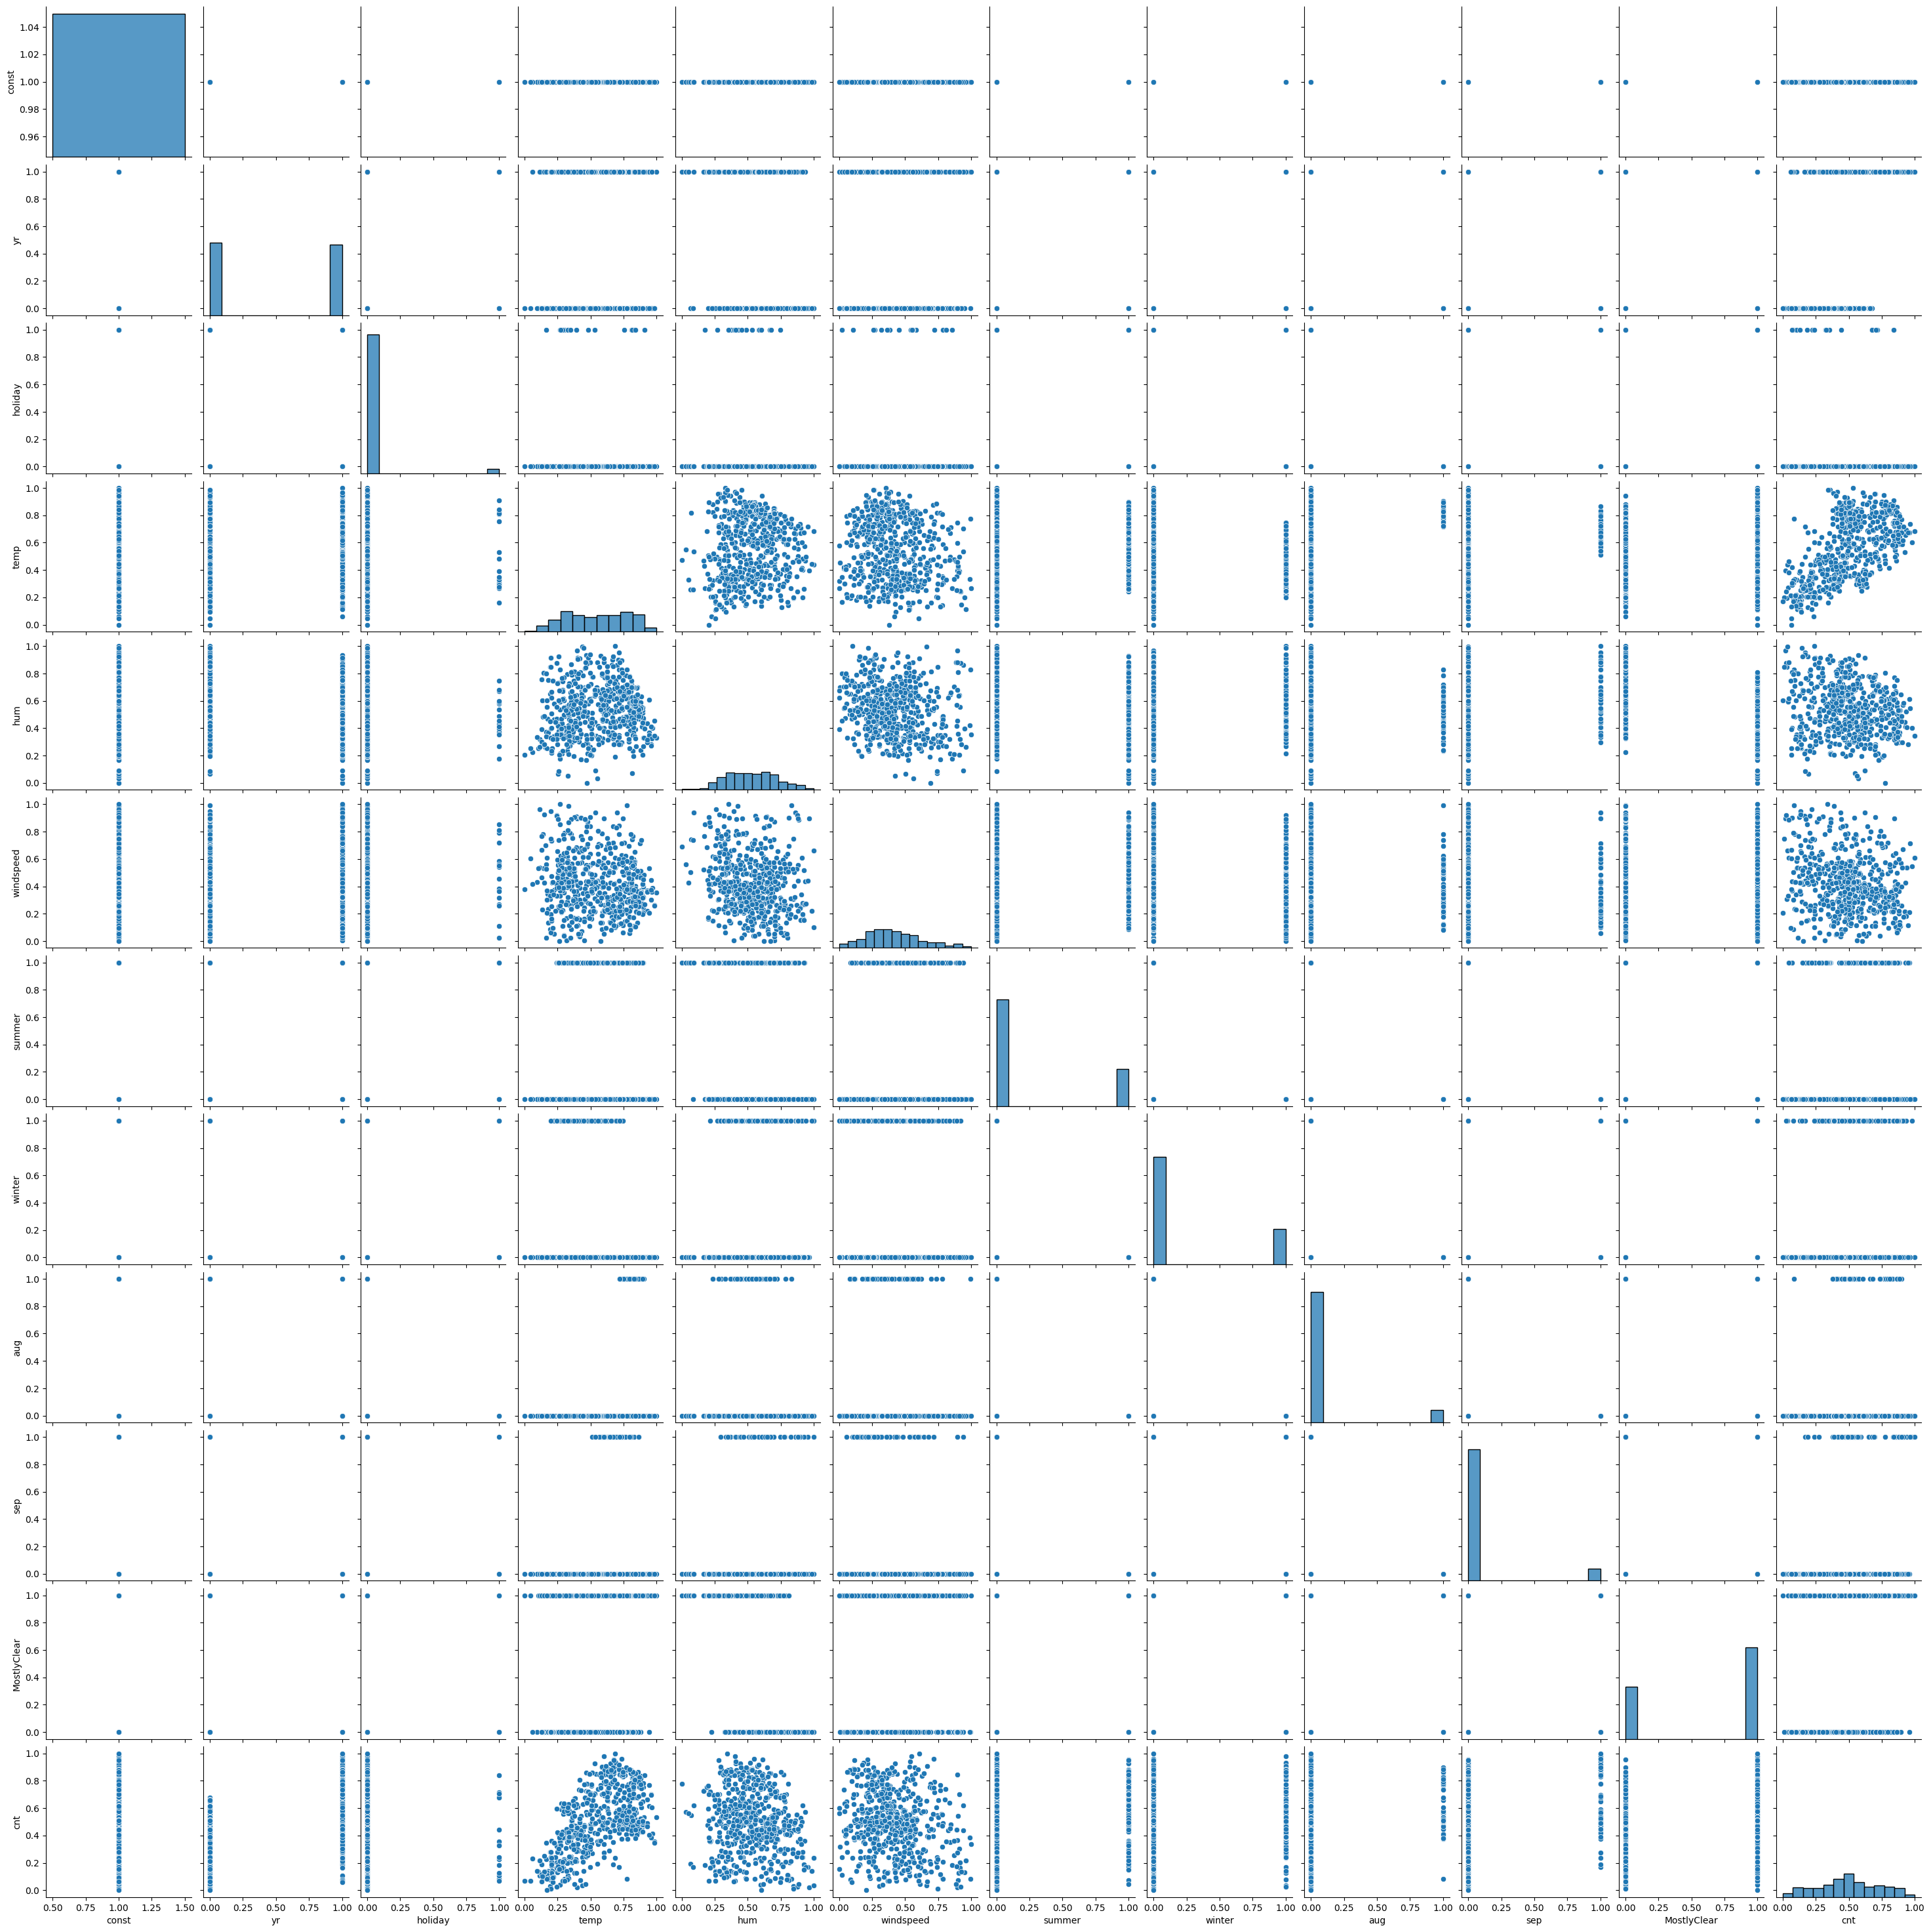

In [44]:
df_full_train = X_train_final.copy()
df_full_train['cnt'] = y_train
sns.pairplot(df_full_train)
plt.show()

- The pair plot does indicate some liner relationship between the features and the target variable (cnt), but it's not obvious.

In [45]:
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     264.4
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          1.01e-204
Time:                        15:25:17   Log-Likelihood:                 526.49
No. Observations:                 571   AIC:                            -1031.
Df Residuals:                     560   BIC:                            -983.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1153      0.025      4.548      

 - In the final model summary you can see that all features have P>|t| < 0.05.  This is enough to state that a relationship between the feastures and the target variable has been observed. 

##  No Multicollinearity 

This will be confirmed by checking that the VIF scores of all features are less than 5.  This ensures the R2-score for each feature is less than 0.80.  So less than 80% of the variance can be explained using the other features in the dataset for any given feature.

In [46]:
check_vif(X_train_final)

       Features    VIF
0         const  38.83
4           hum   1.83
10  MostlyClear   1.68
3          temp   1.48
6        summer   1.38
8           aug   1.37
7        winter   1.31
9           sep   1.20
5     windspeed   1.11
1            yr   1.04
2       holiday   1.01


The VIF is < 5 for all features apart from the constant.  I don't think this is an issue as the constant has no variance.  I think this may be because the holiday field has very little variance as well and it's assuming a correlation

## Observations are independent
To do this I will create a residual time series plot and see if a pattern is observed


Text(0, 0.5, 'residuals')

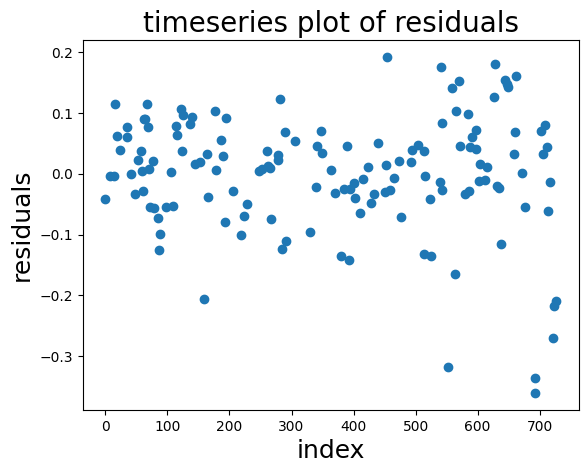

In [47]:
plt.scatter(y_test.index,y_test - y_test_pred )
plt.title('timeseries plot of residuals', fontsize = 20)                  # Plot heading 
plt.xlabel('index', fontsize = 18)                         # X-label
plt.ylabel('residuals', fontsize = 18)                         # y-label


- This appears to show that the residuals show no pattern over time.  
- This can be confirmed with a Durbin-Watson test. In a DW test any value above 1.5 and below 2.5 is deemed as ok.  
- The results of the DW test performed as part of the model fitting can be seen in the model summary.  
- In this case the value was 1.975 and therefore fine.

## Homoscedasticity 

 I will scatter plot the residuals against the predicted values there should be a random distribution


Text(0, 0.5, 'residuals')

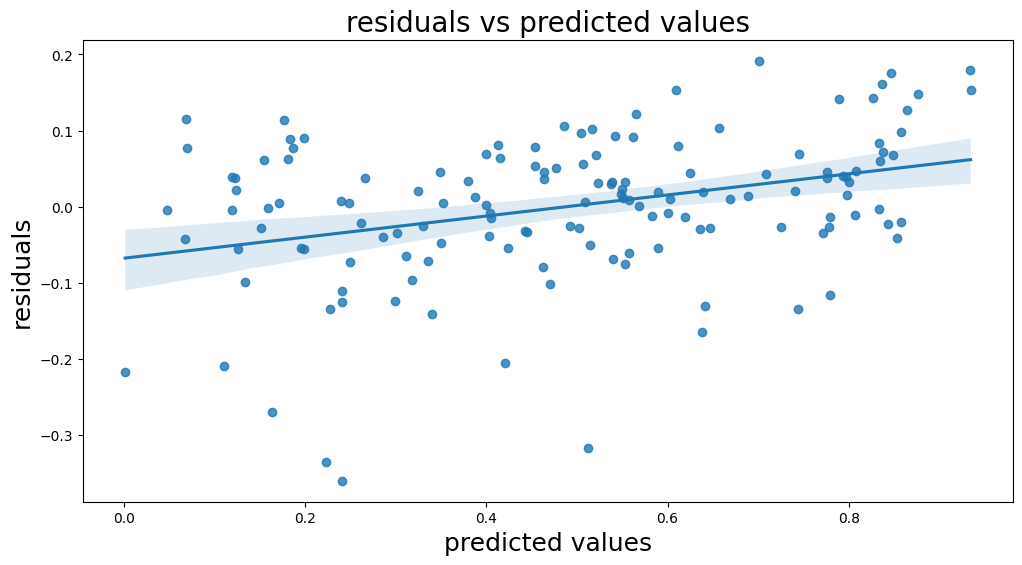

In [48]:
# Scatter plot of error terms 
plt.figure(figsize = (12, 6))
sns.regplot(x=y_test,y=y_test - y_test_pred )
plt.title('residuals vs predicted values', fontsize = 20)                  # Plot heading 
plt.xlabel('predicted values', fontsize = 18)                         # X-label
plt.ylabel('residuals', fontsize = 18)                         # y-label


- This apears to show that the residuals have a mean of approximetly 0 but a slight positive correlation

## Multivariate normality


Text(0.5, 0, 'residuals')

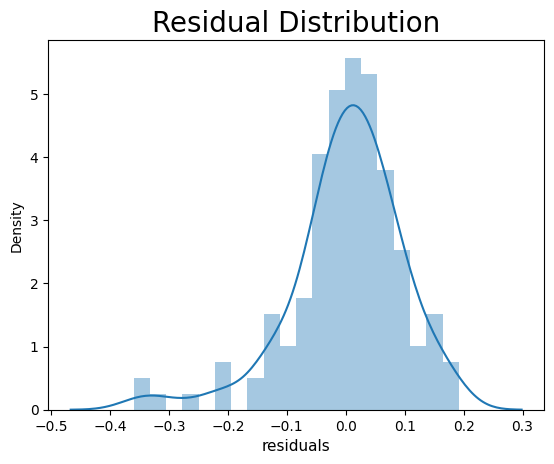

In [49]:
# plot the residual distribution
sns.distplot((y_test - y_test_pred), bins = 20)
plt.title('Residual Distribution', fontsize = 20)                  # Plot heading 
plt.xlabel('residuals', fontsize = 11)                         # X-label

The distribution plot shows that the errors are positively skewed and the distribution is leptokurtic

# Conclusion

While the R2 score obtained on the test data was reasonable (0.84) there are concerns with the model.  The main concern being data quality and the issues regarding the date related fields.  The other areas of consern are the results of the tests for homoscedasticity and multivariate normality.
 
